# Interpolacion de los numeros adimensionales
# Autores: Juan Andres Mendez G.,


> Configurar el ambiente

In [4]:
"""
This jupyter notebook is used to optimize the machine parameters for the industrial machining problems. 
Dimensionless parameters are used to describe the machine behavior.
This is an open-source project. everyone can contribute to the development if the owner is willing to do so.
completely free to use.
I have used the following packages:
1. pandas
2. numpy
3. matplotlib
4. scipy
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
# Use matplotlib's style settings
plt.style.use('dark_background')

>  Carga de datos

En esta sección se va a cargar los datos tomados, para mas información sobre como tomar los datos y cargarlos refierase a la parte de carga de datos en el tutorial.

In [5]:
# Load the data
path='./data/example_data/'#path to the example data
def import_data(file_name,type_of_data):
    """
    This function is used to import the data from either csv or excel files.
    The data is imported as a pandas dataframe.
    The most important part is the labeling in the sheet Machine materials for the excel file, and labels.csv
    with this labels the data can be imported.
    for excel is important that the label name is the same as sheet name.
    args:
        file_name: name of the file
        type_of_data: type of the data, either csv or excel
    returns:
        d: array of DataFrame's
        lb: array of labels of the tooling material
        cost_table: Dataframe of the cost of machining operation
        time_volume_table: Dataframe of the time and volume of machining operation
    """
    if type_of_data=='csv':
        labels=pd.read_csv(file_name)
        lb=labels.to_numpy()
        d={}
        for i in range(len(lb)):
            d[i]=pd.read_csv(path+lb[i,0]+'.csv')
        cost_table=pd.read_csv(path+'cost_table.csv')
        time_volume_table=pd.read_csv(path+'time_volume_table.csv')
    elif type_of_data=='excel':
        labels=pd.read_excel(file_name,sheet_name='Machine materials')
        lb=labels.to_numpy()
        d={}
        for i in range(len(lb)):
            d[i]=pd.read_excel(file_name,sheet_name=str(lb[i,0]))
        cost_table=pd.read_excel(path+'tooling_data.xlsx',sheet_name='Costs')
        time_volume_table=pd.read_excel(path+'tooling_data.xlsx',sheet_name='Time and volume')
    elif type_of_data=='google_spreadsheet':
        labels=pd.read_csv(file_name)
        lb=labels.to_numpy()
        d={}
        for i in range(len(lb)):
            d[i]=pd.read_csv(path+lb[i,0]+'.csv')
        cost_table=pd.read_csv(path+'cost_table.csv')
        time_volume_table=pd.read_csv(path+'time_volume_table.csv')
    return d,lb,cost_table,time_volume_table
df,lb,cost_table,time_volume_table=import_data(path+'tooling_data.xlsx','excel')

# Visualizacion de las tablas
en esta parte se visualiza la carga de datos a los dataframe, esto con el objetivo de revisar que la importación de datos se realizo de manera adecuada.

In [6]:
time_volume_table

Tabla de tiempos y volumen (s, mm^3)        Valor
0  Tp: Tiempo de preparación de la máquina [s]    1800.0000
1    Tt:Tiempo de cambio de la herramienta [s]     900.0000
2            Ti: Tiempo de improductividad [s]    5000.0000
3                Volumen de la materia  [mm^3]  506707.4791

In [7]:
cost_table

Tabla de costos (En pesos)  Costo [COP]
0  Cp: Costos de preparación de la máquina          800
1            Cf: Costo del fluido de corte         1000
2    Com: Costo de operación de la máquina         1350
3             Ci: Costo de improductividad          900
4                  Insumos (Materia prima)         7000
5   Ss: Remuneración de sueldos y salarios       716000
6              CH: Costo de la herramienta         5800
7                                       C1         4050

In [8]:
for i in range(len(lb)):
    print(lb[i,0])
    print(df[i].head(1))
    print('\n')


steel_1020_carbide
   Unnamed: 0  #  Diametro (mm)  Pc Profundidad (mm)  Lm Longitud (mm)  \
0           1  1           24.5                    2                50   

   Tiempo de carga y descarga (s)  T Tiempo de Operación (s)  \
0                            97.6                      321.5   

   Tiempo total de mecanizado (s)  Velocidad angular [1/S]  \
0                           419.1                    12.51   

   Av velocidad de avance (mm/s)  Afiladas #  Desgaste  Valor de venta $  \
0                         0.1555           1      86.2             10000   

   Valor producción $  
0                7116  


steel_1040_carbide
   Unnamed: 0  #  Diámetro (mm)  Pc Profundidad (mm)  Lm Longitud (mm)  \
0           1  1           24.5                    2                50   

   Tiempo de carga y descarga (s)  T Tiempo de Operación (s)  \
0                           125.9                      265.2   

   Tiempo total de mecanizado (s)  Velocidad angular [1/S]  \
0               

# Calculo de los indicadores adimencionales
Con los datos proporcionados se dispone a calcular los indicadores adimencionales $\pi_1\:\pi_2\:\pi_3$

In [9]:
# Parameters
C_p=cost_table.index[cost_table['Tabla de costos (En pesos)']=='Cp: Costos de preparación de la máquina']
C_p=cost_table.loc[C_p,'Costo [COP]']
C_p=float(C_p)
C_f=cost_table.index[cost_table['Tabla de costos (En pesos)']=='Cf: Costo del fluido de corte']
C_f=cost_table.loc[C_f,'Costo [COP]']
C_f=float(C_f)
C_om=cost_table.index[cost_table['Tabla de costos (En pesos)']=='Com: Costo de operación de la máquina']
C_om=cost_table.loc[C_om,'Costo [COP]']
C_om=float(C_om)
C_i=cost_table.index[cost_table['Tabla de costos (En pesos)']=='Ci: Costo de improductividad']
C_i=cost_table.loc[C_i,'Costo [COP]']
C_i=float(C_i)
store=cost_table.index[cost_table['Tabla de costos (En pesos)']=='Insumos (Materia prima)']
store=cost_table.loc[store,'Costo [COP]']
store=float(store)
S_s=cost_table.index[cost_table['Tabla de costos (En pesos)']=='Ss: Remuneración de sueldos y salarios']
S_s=cost_table.loc[S_s,'Costo [COP]']
S_s=float(S_s)
C_H=cost_table.index[cost_table['Tabla de costos (En pesos)']=='CH: Costo de la herramienta']
C_H=cost_table.loc[C_H,'Costo [COP]']
C_H=float(C_H)
C1=C_p+C_f+C_om+C_i
V_MP=time_volume_table.index[time_volume_table['Tabla de tiempos y volumen (s, mm^3)']=='Volumen de la materia  [mm^3]']
V_MP=time_volume_table.loc[V_MP,'Valor']
V_MP=float(V_MP)
#Print the cost of the machining process in COP
print('El costo de preparación de la maquina es:'+"${:,.2f}".format(C_p))
print('El costo del fluido de corte es:'+"${:,.2f}".format(C_f))
print('El costo de operación de la maquina es:'+"${:,.2f}".format(C_om))
print('El costo de improductividad es:'+"${:,.2f}".format(C_i))
print('El costo total de la maquina es:'+"${:,.2f}".format(C1))
print('El costo de los insumos es:'+"${:,.2f}".format(store))
print('El costo de los salarios es:'+"${:,.2f}".format(S_s))
print('El costo de la herramienta es:'+"${:,.2f}".format(C_H))
print('El volumen de la materia prima es: ',V_MP,'[mm^3]')

El costo de preparación de la maquina es:$800.00
El costo del fluido de corte es:$1,000.00
El costo de operación de la maquina es:$1,350.00
El costo de improductividad es:$900.00
El costo total de la maquina es:$4,050.00
El costo de los insumos es:$7,000.00
El costo de los salarios es:$716,000.00
El costo de la herramienta es:$5,800.00
El volumen de la materia prima es:  506707.4791 [mm^3]


In [10]:
for i in range(len(lb)):
    df[i]['V_mr (mm^3)']=df[i]['Lm Longitud (mm)']*df[i]['Av velocidad de avance (mm/s)']*df[i]['T Tiempo de Operación (s)']*df[i]['Pc Profundidad (mm)']
    df[i]['Pi_1']=(C1/df[i]['V_mr (mm^3)'])/(store/V_MP)
    df[i]['CHF $']=(C_H*
    df[i]['T Tiempo de Operación (s)'])/(df[i]['Afiladas #']*df[i]['Tiempo total de mecanizado (s)'])
    df[i]['Pi_2']=(C1/(df[i]['Desgaste']*10**-3))/(df[i]['CHF $']/df[i]['Lm Longitud (mm)'])
    df[i]['Pi_3']=df[i]['Valor de venta $']/df[i]['Valor producción $']


# Grafica de los indicadores adimensionales dividos por grupos
se realiza una grafica de disperción en 3D dividido en el tipo de material de la herramienta

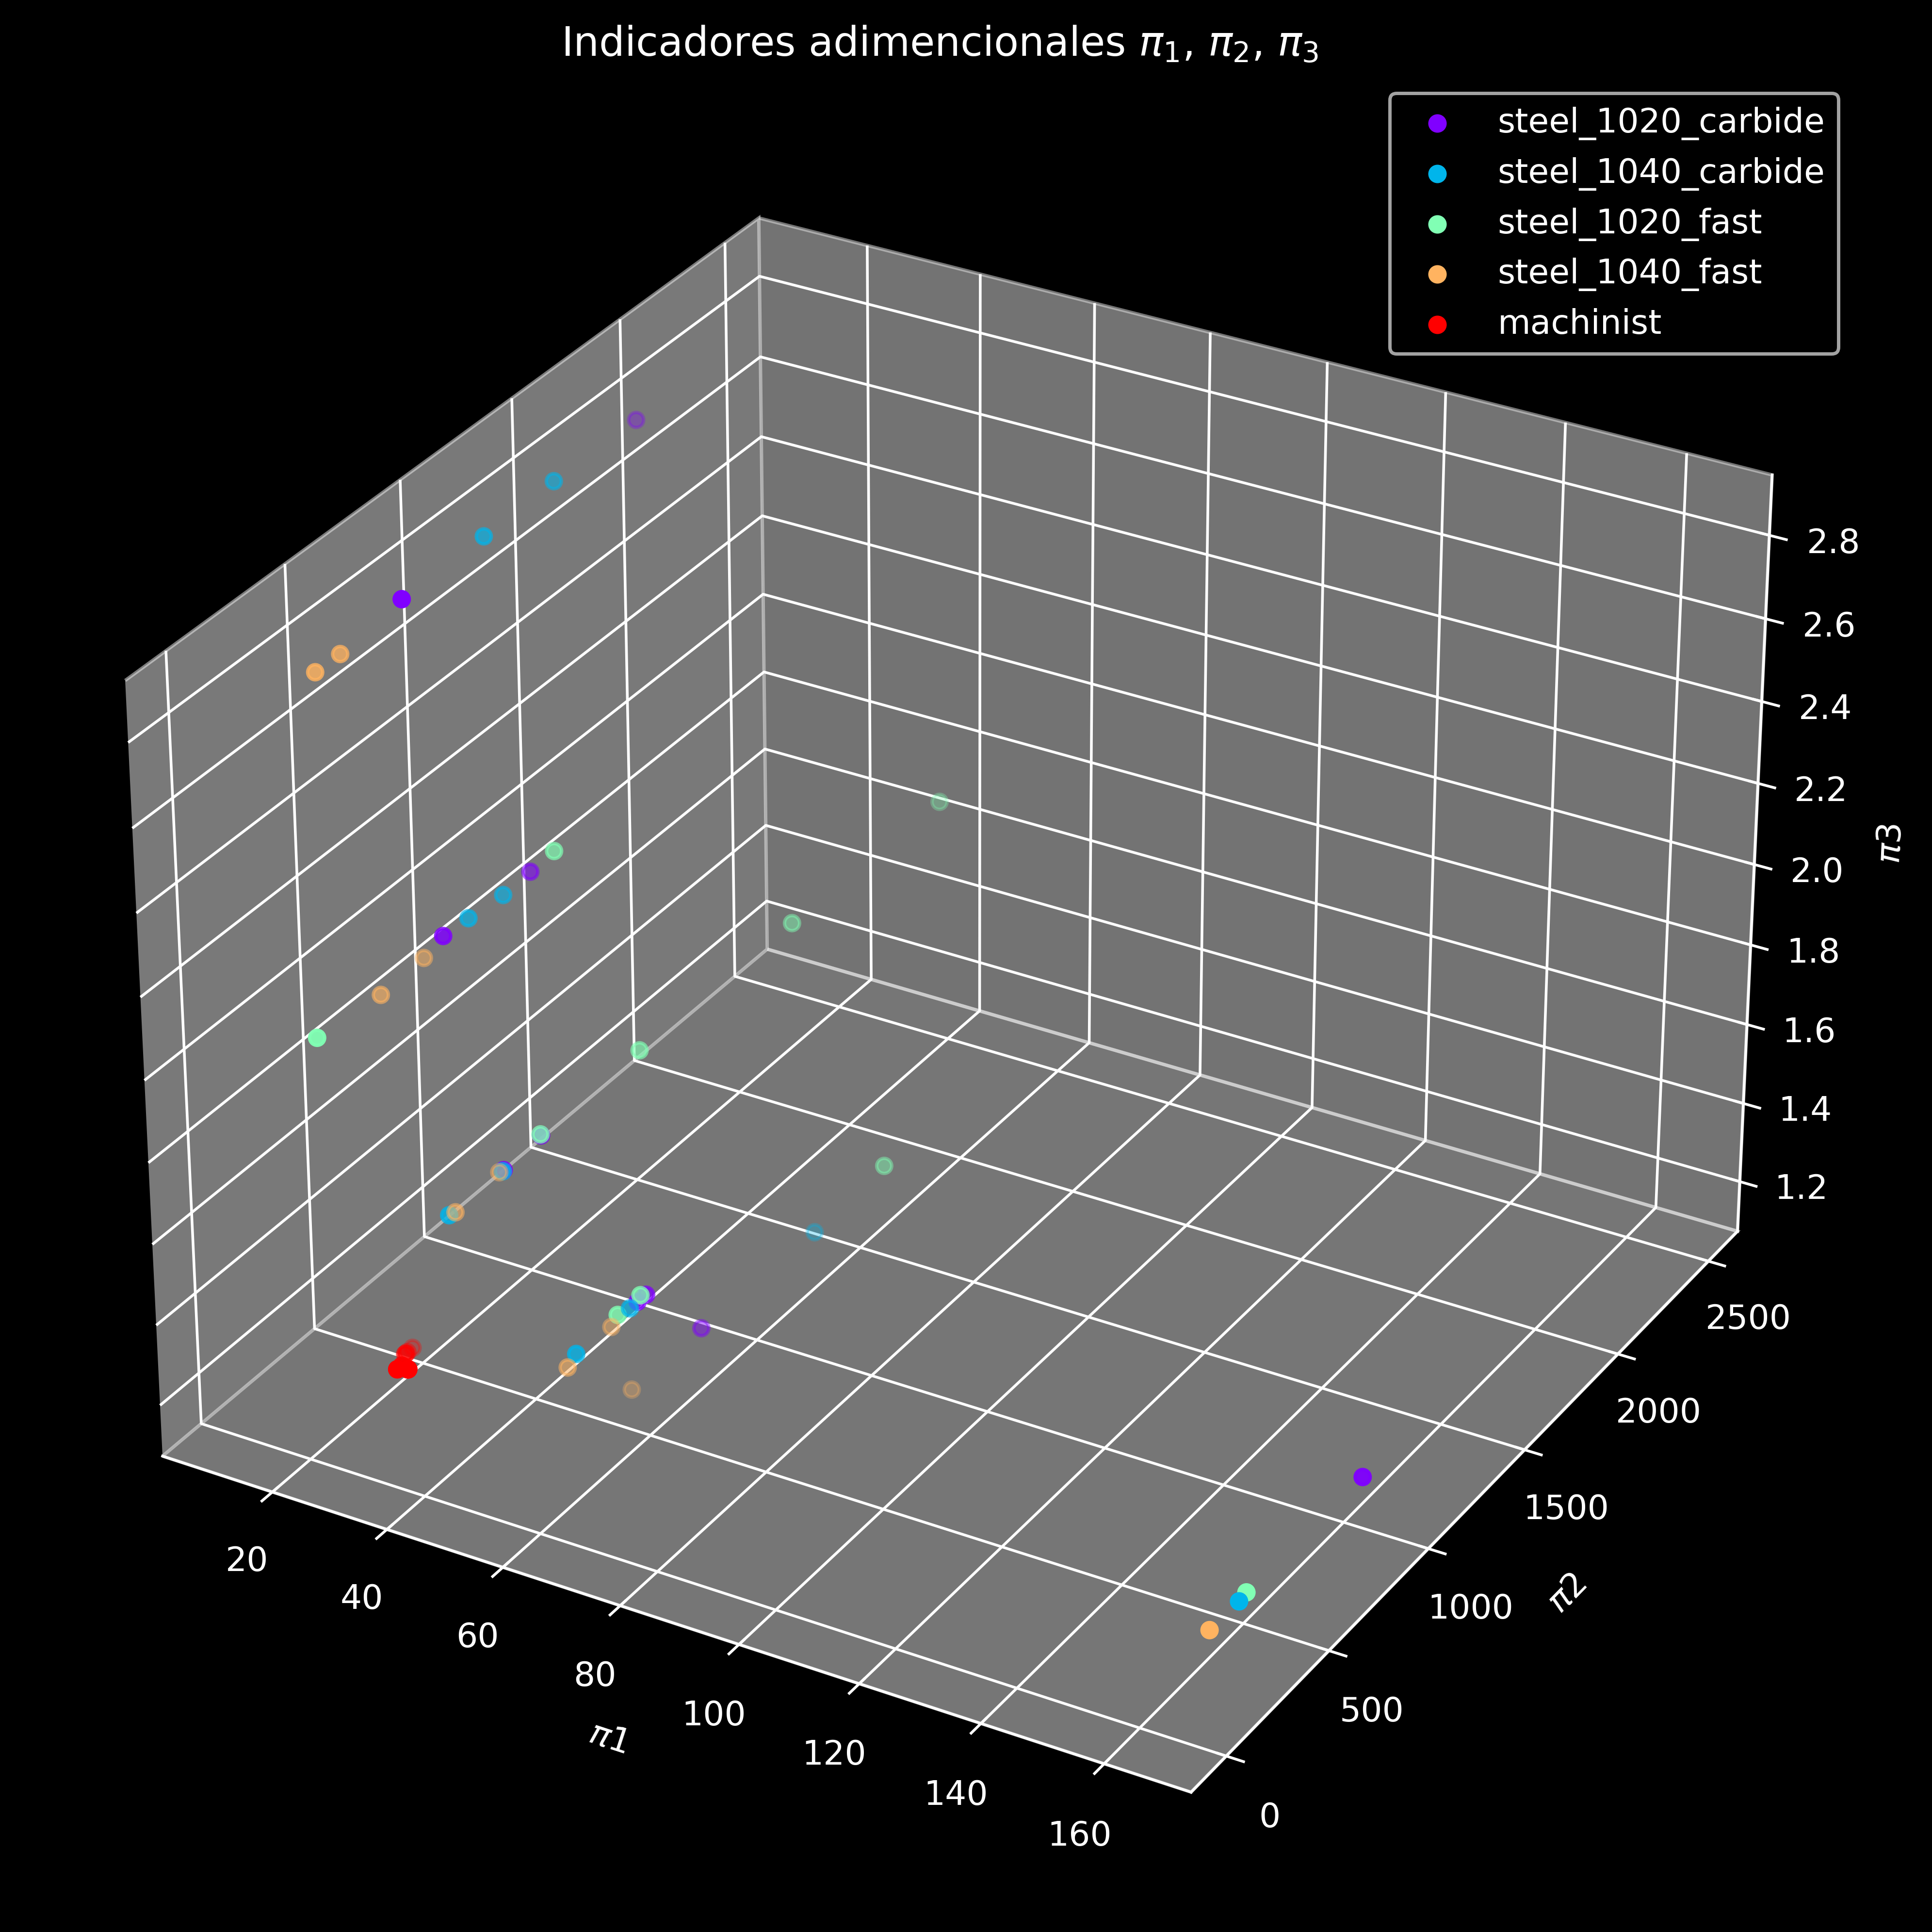

In [11]:
def graph_data(data ,label,ax,c):
    """This function plots the data in the dataframe

    Args:
        data ([pd.DataFrame]): Dataframe of the tooling material data
        label (str): name of the material
        ax (plt): axis of the plot
        c (cm): color of the plot
    """
    ax.scatter(data['Pi_1'],data['Pi_2'],data['Pi_3'],label=label,color=c)

# 3D plot of dimensionless data
fig = plt.figure(figsize=(10,10),dpi=500)
ax = fig.add_subplot(111, projection='3d')
color = iter(cm.rainbow(np.linspace(0, 1, len(lb))))
for i, c in zip(range(len(lb)), color):
    graph_data(df[i],lb[i,0],ax,c)
ax.set_xlabel(r'$\pi 1$')
ax.set_ylabel(r'$\pi 2$')
ax.set_zlabel(r'$\pi 3$')
ax.title.set_text(r'Indicadores adimencionales $\pi_1$, $\pi_2$, $\pi_3$')
plt.legend()
plt.show()

Regreción 3D para hallar la superfice de mayor ajuste a los datos de la forma:
$$z(x,y)=ax^by^c+dx^{\left (c+1\right)}y^{\left (b+1\right)}$$

In [12]:
pi_1=np.array([])
pi_2=np.array([])
pi_3=np.array([])
for i in range(len(lb)):
    """
    In this function we concatenate the data in the dataframe in a single array of pi_1, pi_2 and pi_3
    """
    pi_1=np.append(pi_1,np.array(df[i]['Pi_1']).reshape(10,1))
    pi_2=np.append(pi_2,np.array(df[i]['Pi_2']).reshape(10,1))
    pi_3=np.append(pi_3,np.array(df[i]['Pi_3']).reshape(10,1))

points=np.array([pi_1,pi_2])
# makea a 3d interpolation
grid_x, grid_y = np.mgrid[np.min(pi_1)-0.01*pi_1.std():np.max(pi_1)+0.01*pi_1.std():1000j, np.min(pi_2)-0.01*pi_2.std():np.max(pi_2)+0.01*pi_1.std():1000j]

def curve(data,a,b,c,d):
    """
    This function returns the value of the interpolation function
    """
    x=data[0]
    y=data[1]
    return a*x**b*y**c+d*x**(b+1)*y**(c+1)
# make a 3d interpolation
parameters,cov=curve_fit(curve,points,pi_3,maxfev=100000000)
z=curve([grid_x,grid_y],*parameters)
# calculate the error in std deviation of the parameters
perr=np.sqrt(abs(np.diag(cov)))
parameters_labels=['a','b','c','d']
parameters_df=pd.DataFrame(index=parameters_labels)
parameters_df['Valor']=parameters
parameters_df['Error[dev std]']=perr
# Set index titles
parameters_df.index.name='Parametros'
parameters_df.head()

Valor  Error[dev std]
Parametros                          
a           5.646650        2.329766
b          -0.442820        0.063339
c           0.046888        0.044964
d           0.000010        0.000016

# Grafica de la superfice de mayor ajuste

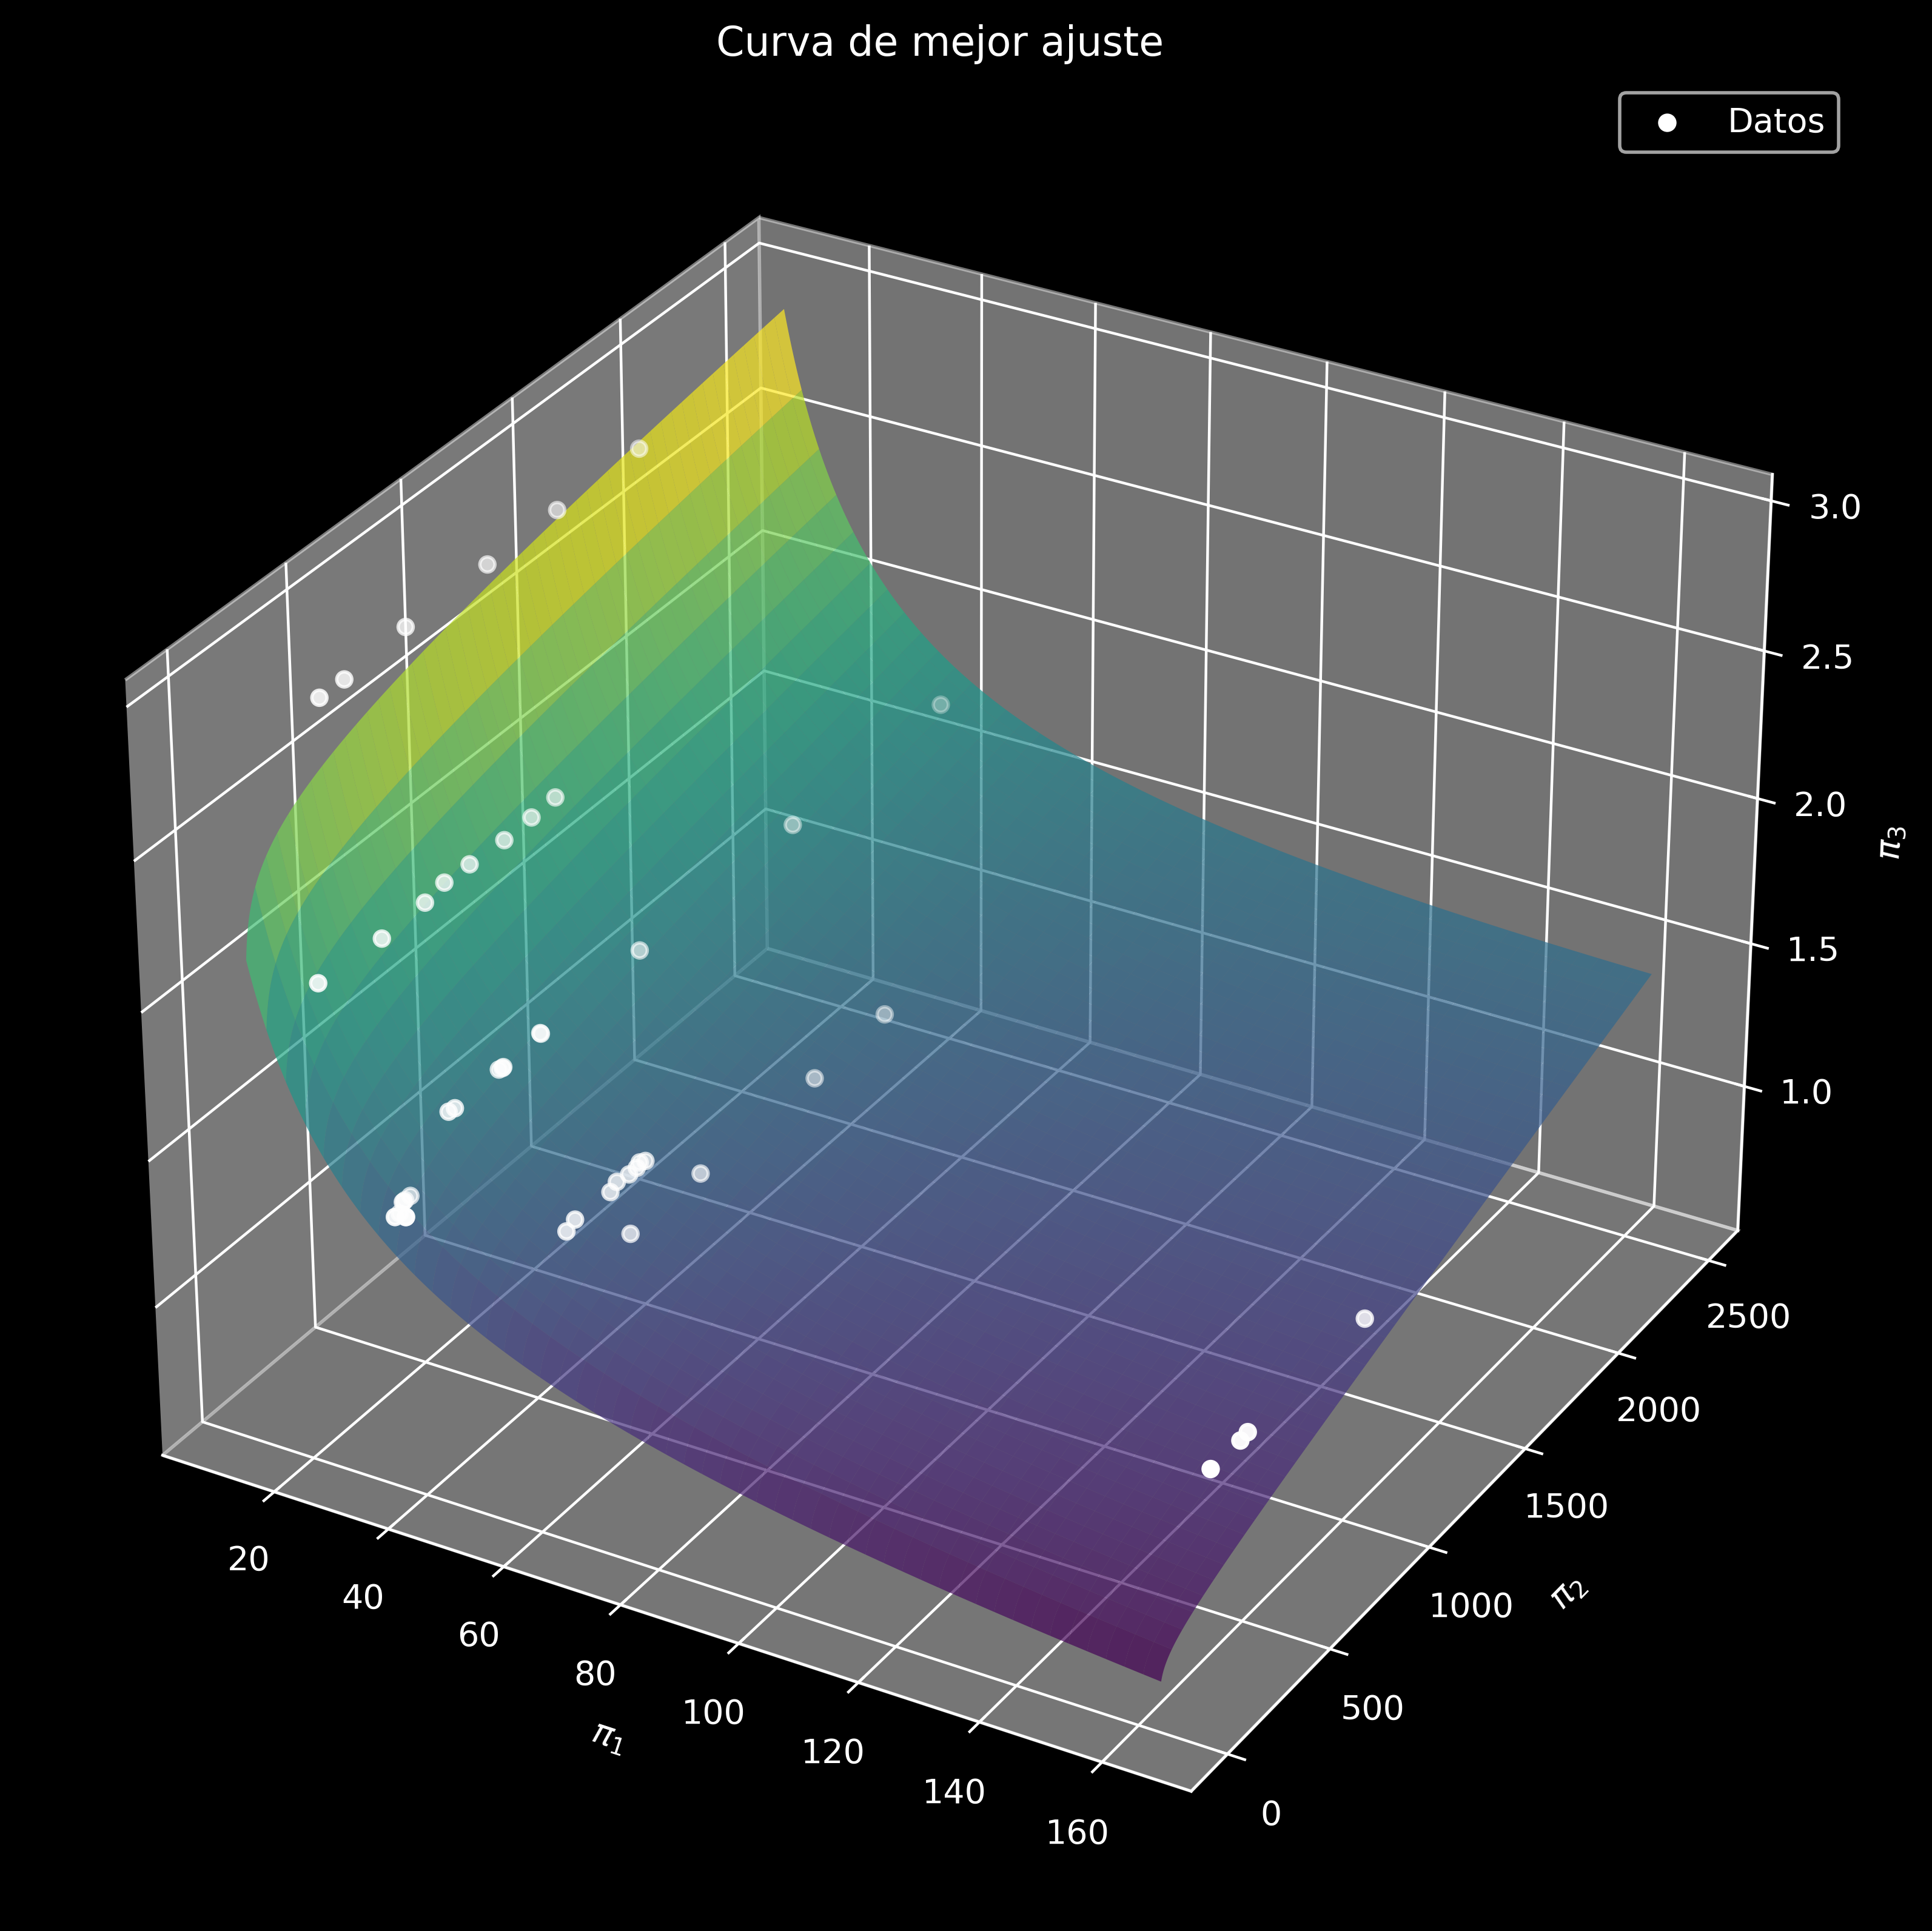

In [13]:
# Plot the 3d interpolation and the training data
fig=plt.figure(figsize=(10,10),dpi=400)
ax=fig.add_subplot(111,projection='3d')
ax.plot_surface(grid_x,grid_y,z,alpha=0.7,cmap='viridis')
ax.scatter(pi_1,pi_2,pi_3,color='white',label='Datos')
ax.set_xlabel(r'$\pi_1$')
ax.set_ylabel(r'$\pi_2$')
ax.set_zlabel(r'$\pi_3$')
ax.title.set_text(r'Curva de mejor ajuste')
ax.legend()
plt.show()


## Grafica de la superficie de mejor ajuste graficando los datos por el tipo de material

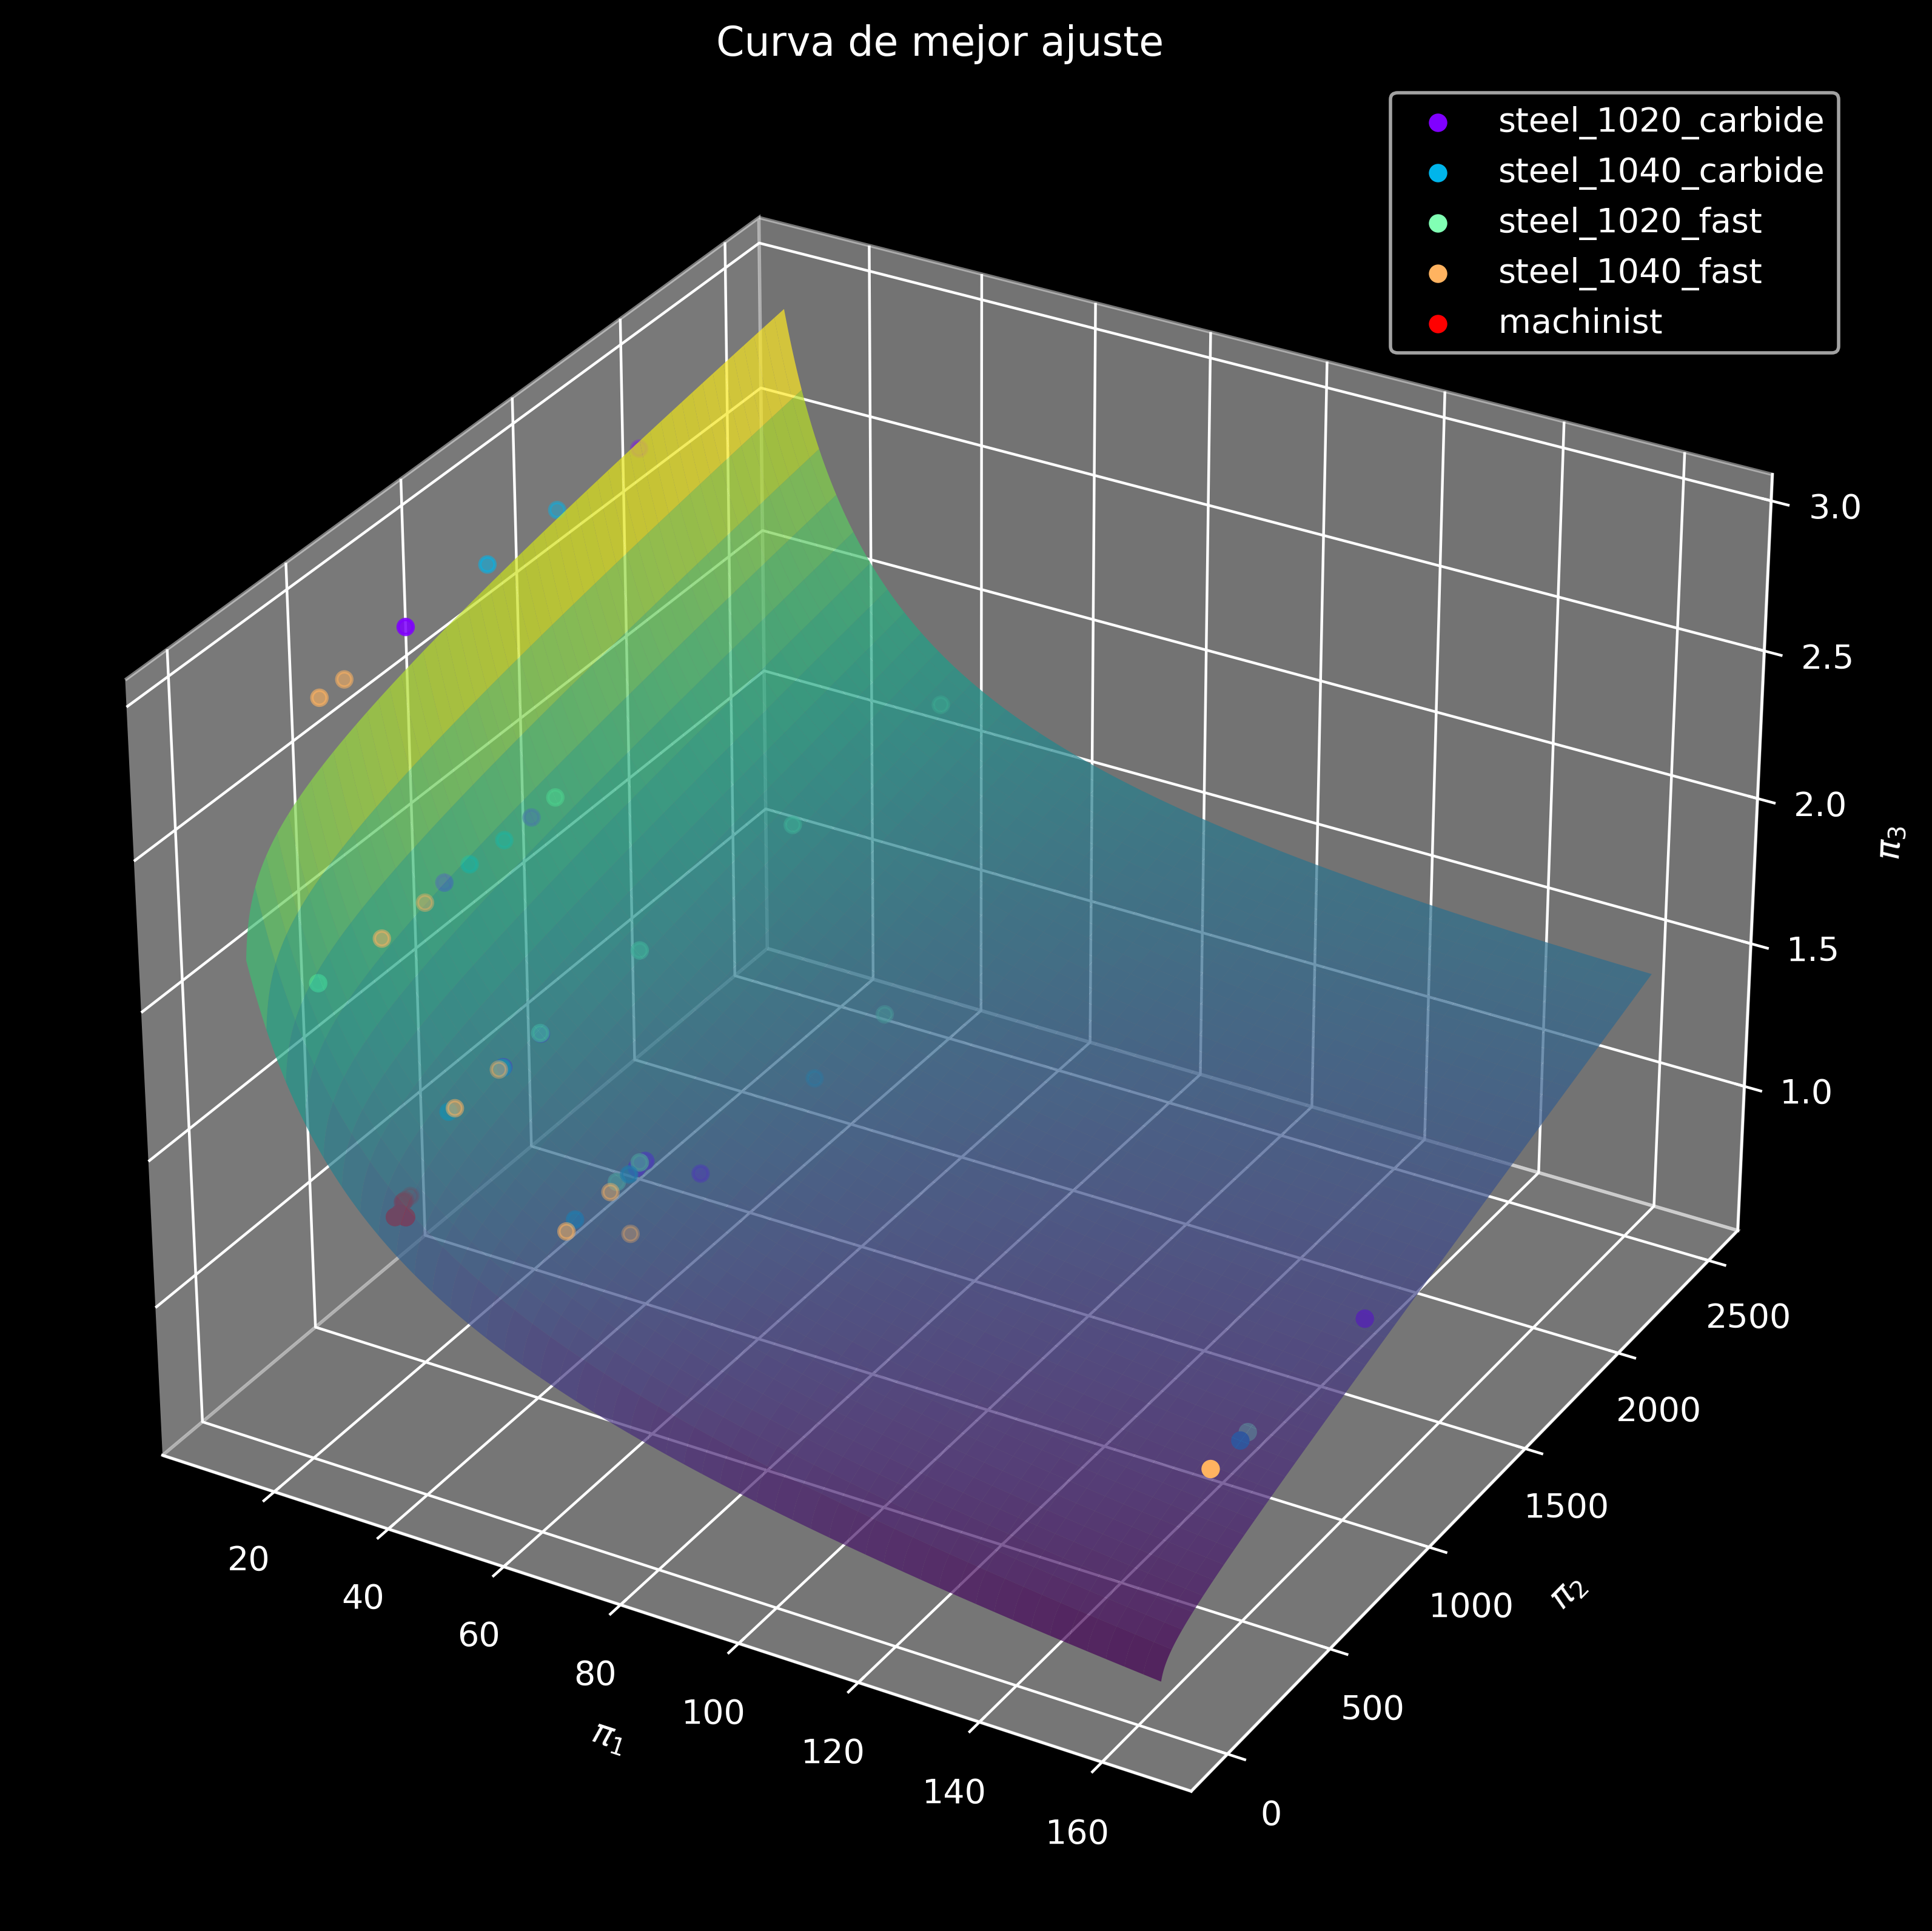

In [14]:
# 3D plot of the interpolation with the training data by material type
fig=plt.figure(figsize=(10,10),dpi=400)
ax=fig.add_subplot(111,projection='3d')
ax.plot_surface(grid_x,grid_y,z,alpha=0.7,cmap='viridis')
color = iter(cm.rainbow(np.linspace(0, 1, len(lb))))
for i, c in zip(range(len(lb)), color):
    graph_data(df[i],lb[i,0],ax,c)
ax.set_xlabel(r'$\pi_1$')
ax.set_ylabel(r'$\pi_2$')
ax.set_zlabel(r'$\pi_3$')
ax.title.set_text(r'Curva de mejor ajuste')
ax.legend()
plt.show()


# Grafica de contorno

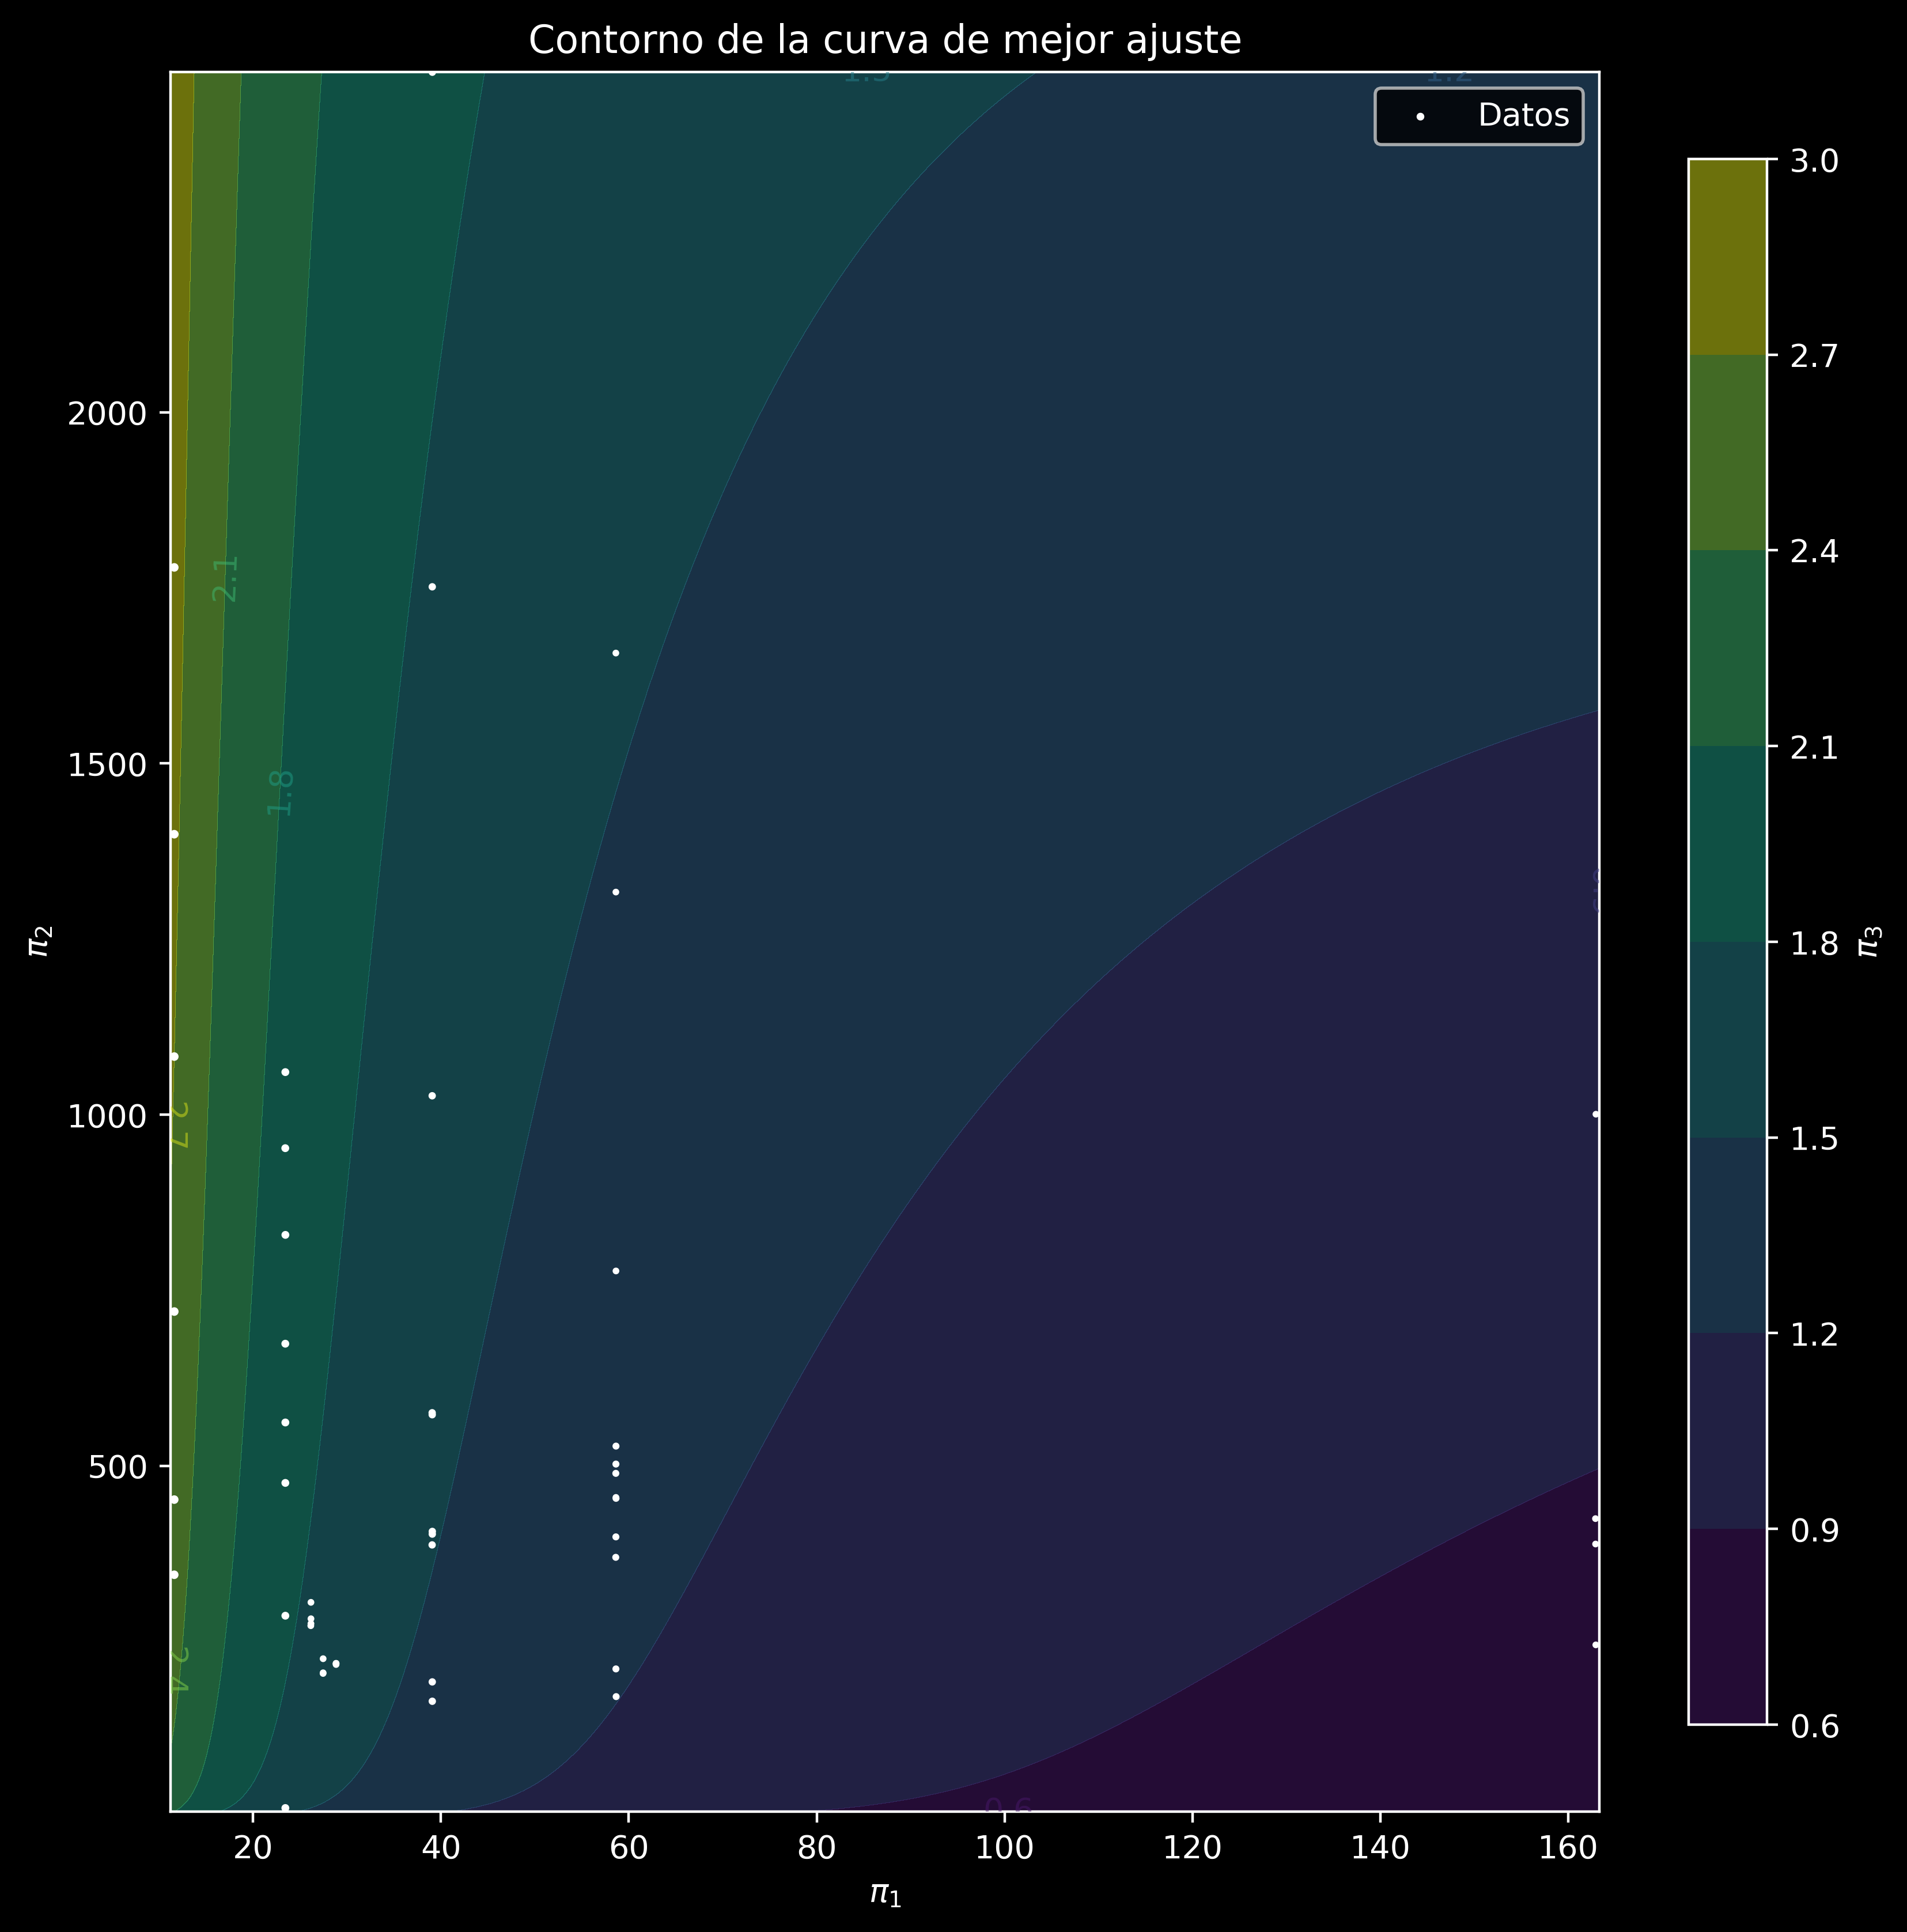

In [15]:
fig,ax=plt.subplots(figsize=(10,10),dpi=400)
cs=ax.contourf(grid_x,grid_y,z,alpha=0.5,cmap='viridis')
ax.clabel(cs,inline=1,fontsize=10)
cb=fig.colorbar(cs,ax=ax,shrink=0.9)
cb.set_label(r'$\pi_3$')
plt.scatter(pi_1,pi_2,pi_3,color='white',label='Datos')
plt.xlabel(r'$\pi_1$')
plt.ylabel(r'$\pi_2$')
plt.title(r'Contorno de la curva de mejor ajuste')
plt.legend()
plt.show()


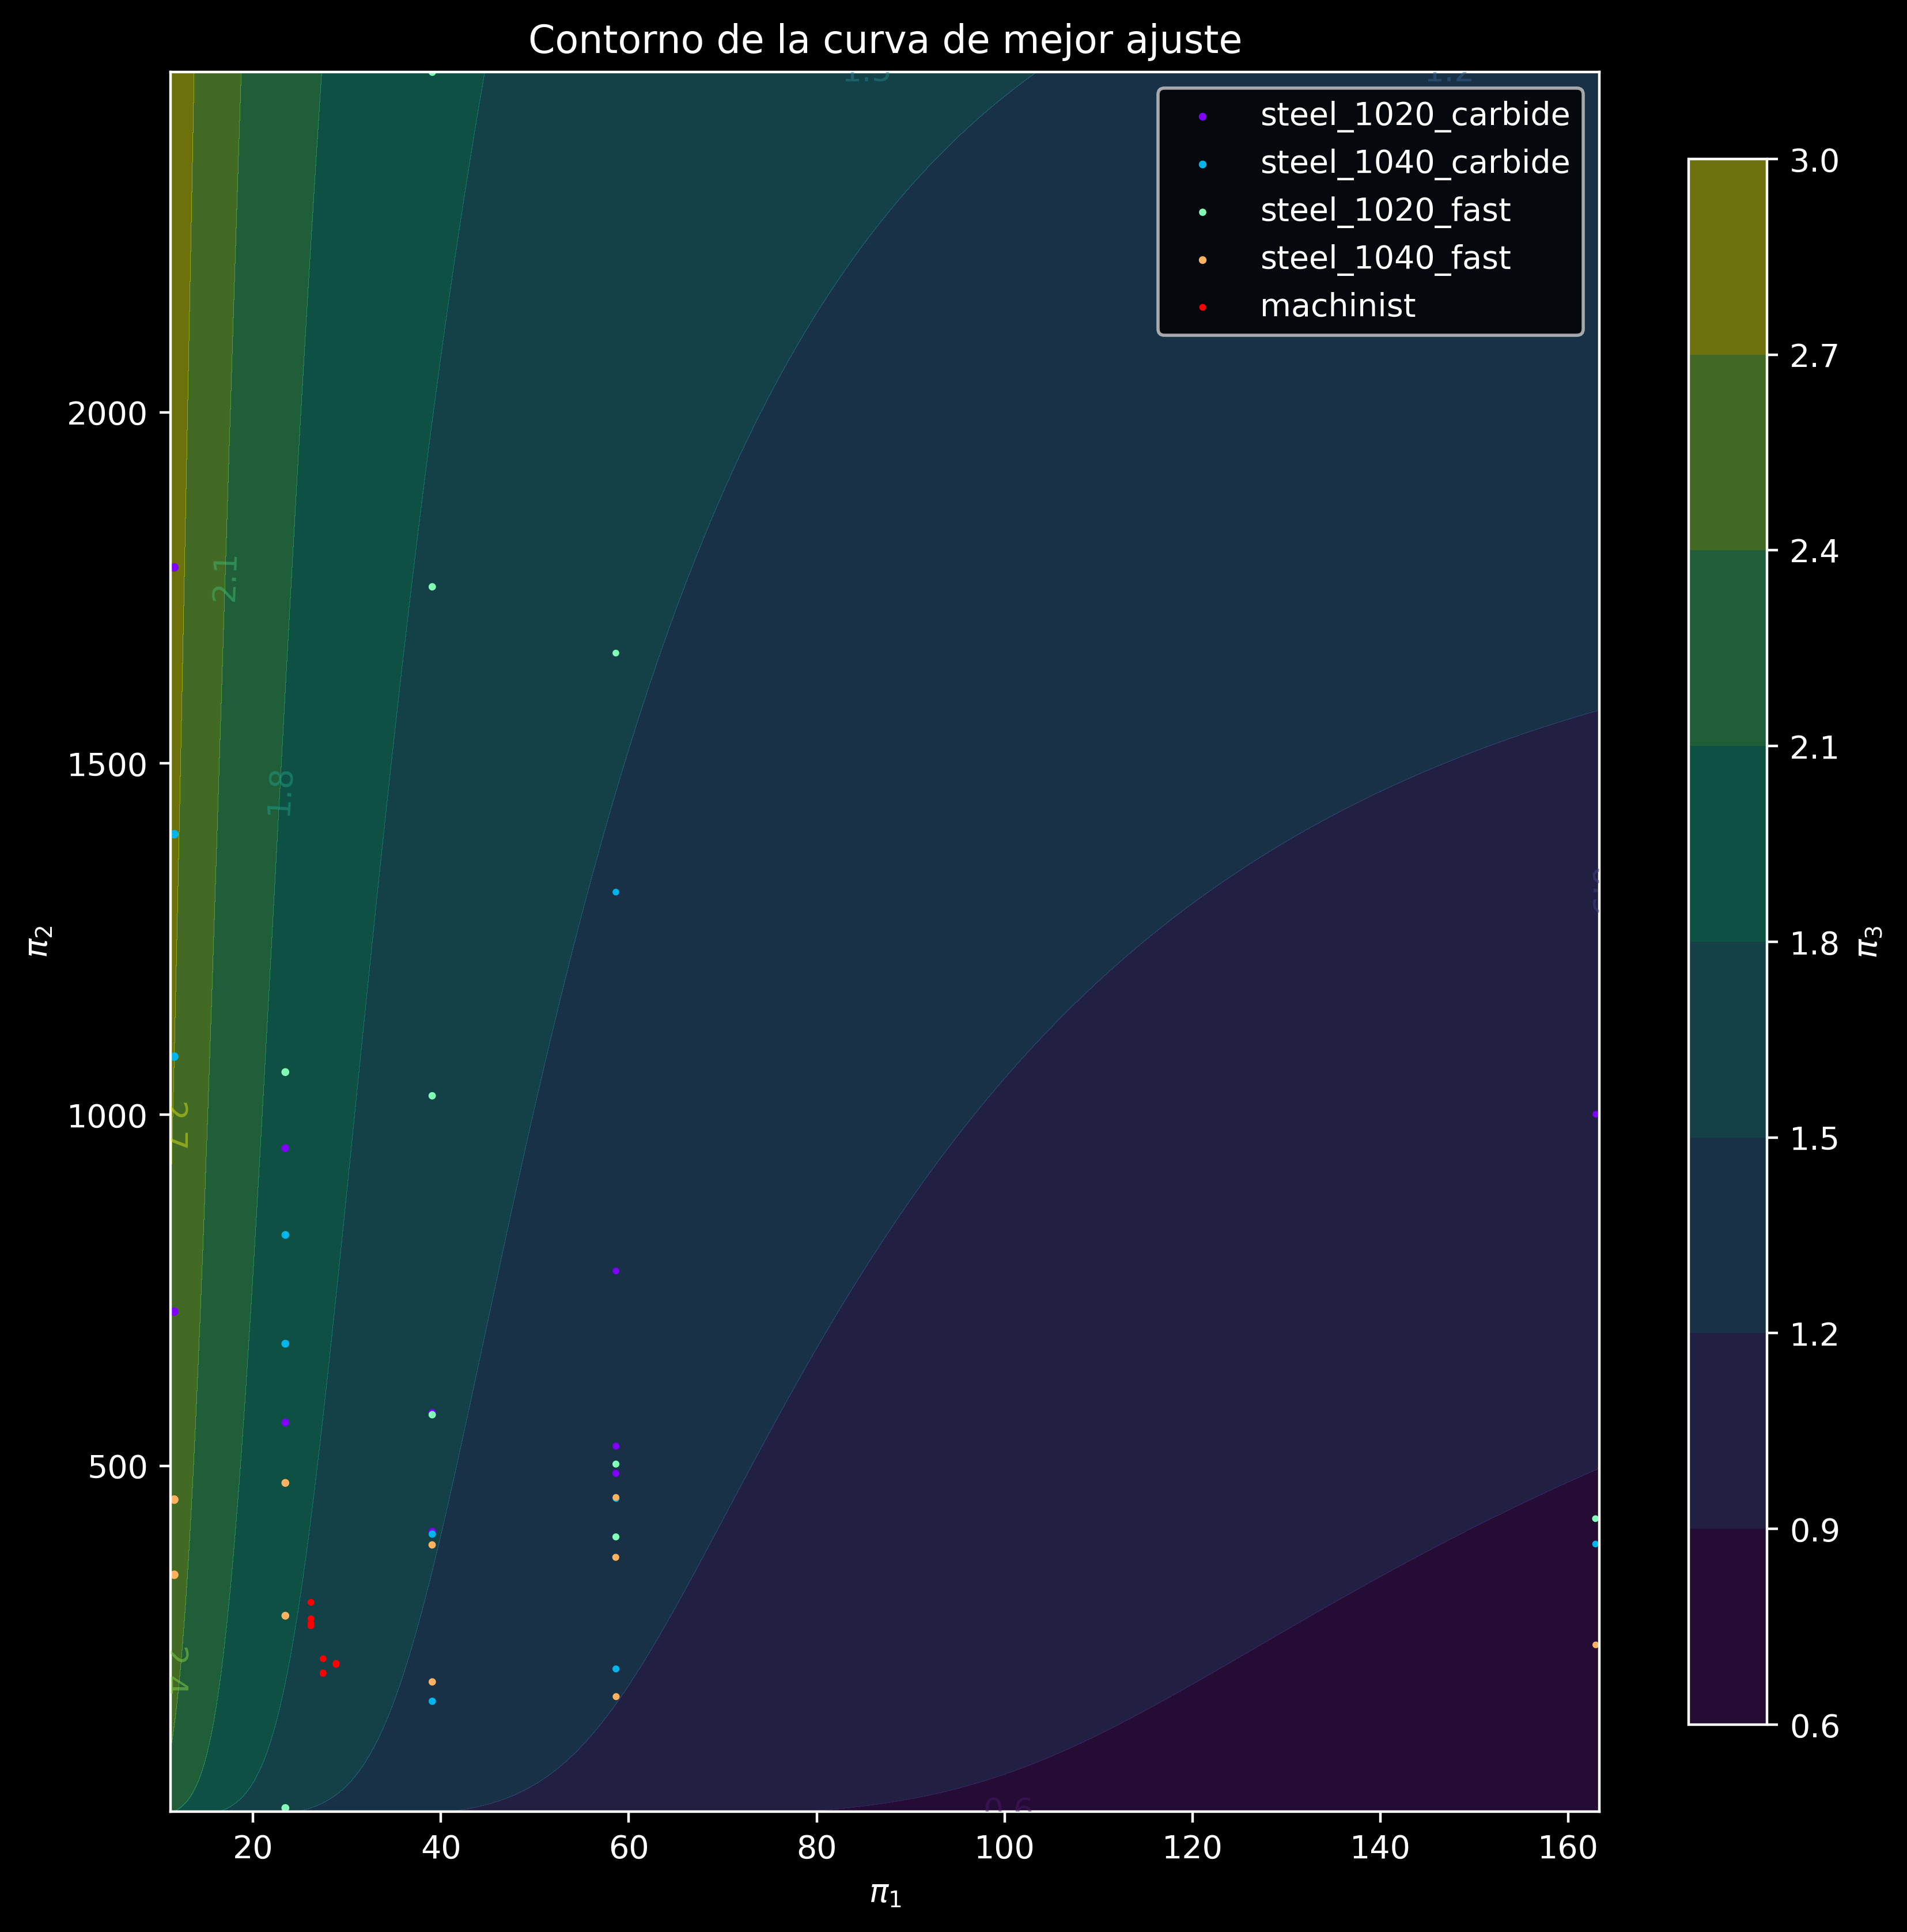

In [16]:
fig,ax=plt.subplots(figsize=(10,10),dpi=400)
cs=ax.contourf(grid_x,grid_y,z,alpha=0.5,cmap='viridis')
ax.clabel(cs,inline=1,fontsize=10)
cb=fig.colorbar(cs,ax=ax,shrink=0.9)
cb.set_label(r'$\pi_3$',color='white')
color = iter(cm.rainbow(np.linspace(0, 1, len(lb))))
for i, c in zip(range(len(lb)), color):
    graph_data(df[i],lb[i,0],ax,c)
plt.xlabel(r'$\pi_1$')
plt.ylabel(r'$\pi_2$')
plt.title(r'Contorno de la curva de mejor ajuste')
plt.legend()
plt.show()

# Optimización 

### Nomenclatura

Símbolo  | Descripción
-------- | ----------------------------------------
$T_p$    | Tiempo de preparación de la máquina (s).
$T_i$    | Tiempo de Improductividad (s).
$T_{cd}$ | Tiempo de carga y descarga de material (s).
$T_{t}$   | Tiempo de cambio de la herramienta (s).
$C_p$    | Costo de preparación de la máquina ($).
$C_i$    | Costo de improductividad ($).
$C_p$    | Costo de preparación de la máquina ($).
$C_f$    | Costo del fluido de corte ($).
$C_{om}$ | Costo de operacion de la máquina ($).
$V_b$    | Desgaste de operación  de la máquina ($\mu m$).
$A_v$    | Velocidad de avance del movimiento
$P_c$    | Profundidad de corte (mm)
$L_m$    | Longitud mecanizada de material (mm)
$T$      | Tiempo efectivo de mecanizado (min)
$V_{MR}$ | Volumen de material retirado (mm^3)
$T_{OHP}$| tiempo de operación de la herramienta (s)
$C_{MP}$ | Costo de materia prima ($).
$V_{MP}$ | Volumen de materia prima ($mm^3$)



$$\pi_1= \frac{\frac{C_p+C_i+C_f+C_{om}}{V_{MR}}}{\frac{C_{MP}}{V_{MP}}}$$

$$C_1=C_p+C_i+C_f+C_{om}$$
$$C_{HF}=\left(\frac{C_H\times T_{OHP}}{NF\times T_{TM}}\right)$$
$$\pi_2=\frac{\frac{C_1}{V_b}}{\frac{C_{HF}}{L_m}}$$

$$\pi_3=\frac{V_v}{V_p}$$

Selecione la rentabilidad minima que desea de la operación de maquinado
----Presione enter para que la rentablidad minima sea la media de los datos---
La rentabilidad minima es:1.8


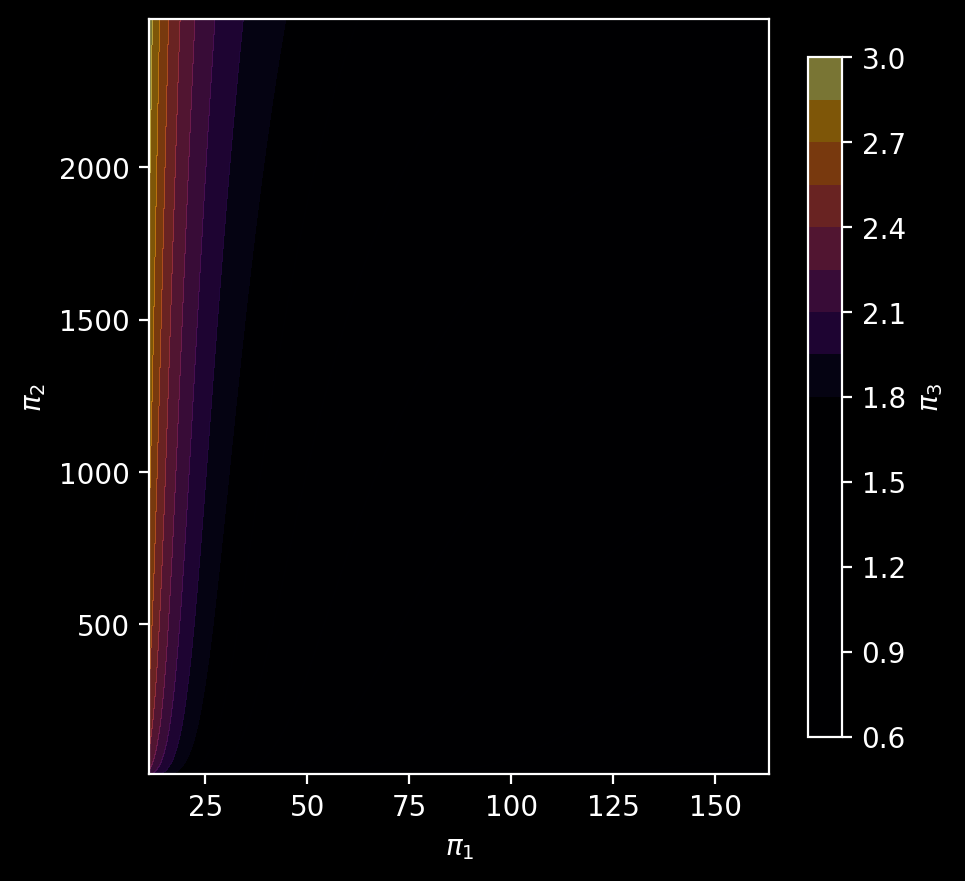

In [17]:
# Function to calculate the best operation point
print('Selecione la rentabilidad minima que desea de la operación de maquinado')
print('----Presione enter para que la rentablidad minima sea la media de los datos---')
def best_point(min_rent=z.mean()):
    """
    This function returns the best operation point in area
    """
    fig,ax=plt.subplots(figsize=(5,5),dpi=200)
    cs=ax.contourf(grid_x,grid_y,z,alpha=0.5,levels=20,vmin=min_rent,cmap='inferno')
    cb=fig.colorbar(cs,ax=ax,shrink=0.9)
    cb.set_label(r'$\pi_3$',color='white')
    ax.set_xlabel(r'$\pi_1$')
    ax.set_ylabel(r'$\pi_2$')

# Select the minimum rentability

min_rent=input('Rentabilidad minima:')
if min_rent=='':
    min_rent=z.mean()
else:
    min_rent=float(min_rent)
print('La rentabilidad minima es:'+str(min_rent))
best_point(min_rent)


In [18]:
# Best operation point selected indcadors
print('Ingrese los numeros adimensionales selecionados')
print('Seleciona el indicador pi_1')
pi_1_opt=float(input('pi_1:'))
print('pi_1:'+"{:.2f}".format(pi_1_opt))
print('Seleciona el indicador pi_2')
pi_2_opt=float(input('pi_2:'))
print('pi_2:'+"{:.2f}".format(pi_2_opt))
print('Seleciona el indicador pi_3')
pi_3_opt=float(input('pi_3:'))
print('pi_3:'+"{:.2f}".format(pi_3_opt))

Ingrese los numeros adimensionales selecionados
Seleciona el indicador pi_1
pi_1:12.25
Seleciona el indicador pi_2
pi_2:250.00
Seleciona el indicador pi_3
pi_3:2.25


In [19]:
# Calculate the optimal cost

#Parameters
P_c=7#[mm] Profundidad del corte
L_m=60#[mm] Longitud mecanizada
A_v=0.2094#[mm/s] Avance
C_MP=7000#[$] Costo de materia prima
N_f=2#Numero de filos
V_MP=506707.4791#[mm^3] Volumen de materia prima
#[s] Tiempo de herramienta
T_H=np.array([])
for i in range(len(lb)):
    T_H=np.append(T_H,np.array(df[i]['Tiempo de carga y descarga (s)']))
T_h=T_H.mean()

def optimal_cost(pi_1_e,pi_2_e,pi_3_e):
    """
    This function returns the optimal cost of the operation
    """
    pi_1_eq = lambda T_POH:-pi_1_e+(C1/(P_c*L_m*A_v*T_POH))/(C_MP/V_MP)
    T_POH=fsolve(pi_1_eq,100)
    pi_2_eq = lambda V_B:-pi_2_e+(C1/(V_B*10**-3))/(((C_H*T_POH)/(N_f*(T_POH+T_h)))/L_m)
    V_B=fsolve(pi_2_eq,1000)
    C_HF=(C_H*T_POH)/(N_f*(T_POH+T_h))
    return T_POH, V_B, C_HF
T_POH, V_B, C_HF=optimal_cost(pi_1_opt,pi_2_opt,pi_3_opt)
print('El tiempo de operación optimo es: '+"{:.2f}".format(float(T_POH))+'[s]')
print('El tiempo medio de carga es: '+"{:.2f}".format(float(T_h))+'[s]')
print('El volumen removido optimo es: ',np.round(P_c*L_m*A_v*float(T_POH),3),'[mm^3]')
print('El Desgaste optimo de la herramienta es: ',np.round(V_B,3),r'[µm]')
print('El costo de herramienta por filo optimo es: ',np.round(float(C_HF),3),'[$]')

El tiempo de operación optimo es: 272.11[s]
El tiempo medio de carga es: 88.97[s]
El volumen removido optimo es:  23931.957 [mm^3]
El Desgaste optimo de la herramienta es:  [444.757] [µm]
El costo de herramienta por filo optimo es:  2185.461 [$]
